In [1]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import torch
import os

c:\Users\User\miniconda3\envs\eda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def keyword_similarity_analysis(
    review_csv_path,
    categories,
    model_name='BM-K/KoSimCSE-roberta-multitask',
    threshold=0.45,
    n=3,
    save_path='keyword_result.csv',
    font_family='Malgun Gothic',
    show_plot=True
):
    """
    관광지 리뷰 데이터에서 카테고리별 유사도 기반 키워드 추출 및 등장 빈도 시각화 함수
    
    Parameters
    ----------
    review_csv_path : str
        리뷰 데이터가 저장된 CSV 파일 경로
    categories : list of str
        분석할 카테고리 및 설명 리스트
    model_name : str
        임베딩 모델 이름
    threshold : float
        키워드 추출 시 유사도 임계값
    n : int
        추출할 키워드 최대 개수
    save_path : str
        결과 저장 파일 경로
    font_family : str
        한글 폰트명 (윈도우: 'Malgun Gothic', 맥: 'AppleGothic', 리눅스: 'NanumGothic')
    show_plot : bool
        그래프 표시 여부
    """
    # 한글 폰트 설정
    plt.rcParams['font.family'] = font_family
    plt.rcParams['axes.unicode_minus'] = False

    # 데이터 로드
    df = pd.read_csv(review_csv_path)

    # 임베딩 모델 로드
    model = SentenceTransformer(model_name)

    # 카테고리 임베딩
    category_embeddings = model.encode(
        categories,
        batch_size=16,
        show_progress_bar=True
    )

    # 리뷰 임베딩
    df['embedding'] = df['text'].apply(lambda x: model.encode(x))

    # 유사도 계산 함수
    def calc_sim(emb):
        return cosine_similarity([emb], category_embeddings)[0]
    df['similarities'] = df['embedding'].apply(calc_sim)

    # 관광지별 평균 유사도 계산
    place_sims = df.groupby('place')['similarities'].apply(
        lambda sims: np.mean(np.stack(sims.to_list()), axis=0)
    )
    place_sims = pd.DataFrame(
        place_sims.tolist(),
        index=place_sims.index,
        columns=categories
    )

    # 키워드 추출 함수
    def extract_keywords(row, n=n, threshold=threshold):
        vals = row.values
        indices = np.argsort(vals)[::-1]
        results = []
        for idx in indices[:n]:
            if vals[idx] >= threshold:
                kwd = categories[idx].split(':')[0].strip()
                results.append(kwd)
        if not results:
            results = [categories[indices[0]].split(':')[0].strip()]
        return ', '.join(results)

    place_sims['top_keywords'] = place_sims.apply(
        extract_keywords, axis=1
    )

    # 결과 저장
    place_sims.to_csv(save_path, encoding='utf-8-sig')

    # 전체 키워드 카운팅
    all_keywords = []
    for kws in place_sims['top_keywords']:
        all_keywords.extend([kw.strip() for kw in kws.split(',') if kw.strip()])
    keyword_counts = Counter(all_keywords)
    count_df = pd.DataFrame(keyword_counts.items(), columns=['keyword', 'count'])
    count_df = count_df.sort_values('count', ascending=True)

    # 시각화
    if show_plot:
        plt.figure(figsize=(10, 6))
        plt.barh(count_df['keyword'], count_df['count'])
        plt.xlabel('등장 빈도 (관광지 수)')
        plt.title('관광지 리뷰 기반 키워드 등장 빈도')
        plt.tight_layout()
        plt.show()
    
    return place_sims, count_df

# 함수 호출 예시
# place_sims, count_df = keyword_similarity_analysis(
#     review_csv_path="C:/Users/User/Vscode/EDA25-1/data/naver_map_reviews_top.csv",
#     categories=categories,
#     model_name='BM-K/KoSimCSE-roberta-multitask',
#     threshold=0.3,
#     n=2,
#     save_path="C:/Users/User/Vscode/EDA25-1/data/tourist_spot_top2_keywords_KoSimCSE.csv",
#     font_family='Malgun Gothic'
# )


In [3]:
categories = [
    '자연: 산, 바다, 호수 등 자연 경관',
    '역사: 유적지, 기념물, 역사적 장소',
    '문화: 박물관, 미술관, 공연장 등 문화시설',
    '레저스포츠: 야외 스포츠, 액티비티',
    '쇼핑: 쇼핑센터, 시장, 기념품점',
    '음식: 맛집, 카페, 음식거리',
    '숙박: 호텔, 펜션, 리조트 등 숙박시설',
    '체험: 현지 체험 활동, 공방, 클래스 등',
    '힐링: 휴양림, 스파, 온천 등 휴식 시설',
    '축제: 지역 축제, 행사',
    '도시: 도심 관광, 랜드마크, 시내 명소',
    '종교: 사찰, 교회, 성지 등 종교 시설',
    '사진: 사진 촬영 스팟, 포토존',
    '가족: 놀이공원, 어린이 시설 등 가족 단위 관광지',
    '야경: 야경 명소, 전망대 등 야간 경관',
    '산책: 산책로, 공원 등 걷기 좋은 장소',
    '전통: 전통문화 체험, 민속촌 등',
    '예술: 예술 거리, 갤러리, 창작 공간',
    '캠핑: 캠핑장, 글램핑 시설 등 야외 숙박 체험'
]

model_list = [
    'BM-K/KoSimCSE-roberta-multitask',       # KoSimCSE-RoBERTa-multitask
    'BM-K/KoSimCSE-bert-multitask',          # KoSimCSE-BERT-multitask
    'snunlp/KR-SBERT-V40K-klueNLI-augSTS',   # SNUNLP SBERT
    'upskyy/bge-m3-korean',                  # BGE-m3-korean
]

threshold_list = [0.3, 0.35, 0.4, 0.45, 0.5]

csv_path = "C:/Users/User/Vscode/EDA25-1/data/naver_map_reviews_top.csv"
font_family = 'Malgun Gothic'
n = 2

result_dir = "C:/Users/User/Vscode/EDA25-1/data/keyword_exp_results"
os.makedirs(result_dir, exist_ok=True)


[실험] model: BM-K/KoSimCSE-roberta-multitask, threshold: 0.3 → C:/Users/User/Vscode/EDA25-1/data/keyword_exp_results/result_BM-K_KoSimCSE-roberta-multitask_th0.30_n2.csv


No sentence-transformers model found with name BM-K/KoSimCSE-roberta-multitask. Creating a new one with mean pooling.
Batches: 100%|██████████| 2/2 [00:00<00:00, 16.51it/s]


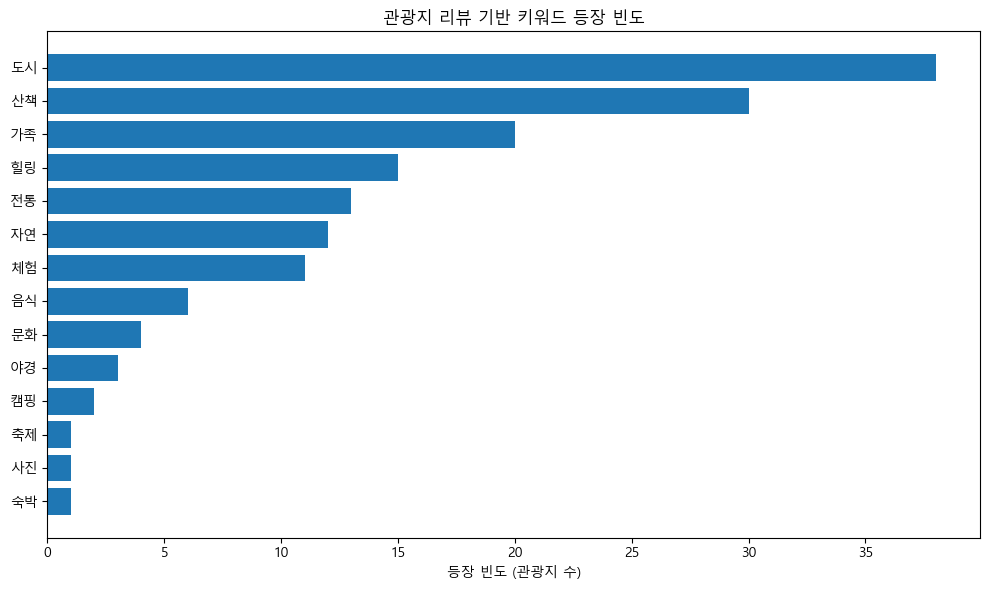

  keyword  count
1      도시     38
6      산책     30
4      가족     20
5      힐링     15
2      전통     13

[실험] model: BM-K/KoSimCSE-roberta-multitask, threshold: 0.35 → C:/Users/User/Vscode/EDA25-1/data/keyword_exp_results/result_BM-K_KoSimCSE-roberta-multitask_th0.35_n2.csv


No sentence-transformers model found with name BM-K/KoSimCSE-roberta-multitask. Creating a new one with mean pooling.
Batches: 100%|██████████| 2/2 [00:00<00:00, 125.54it/s]


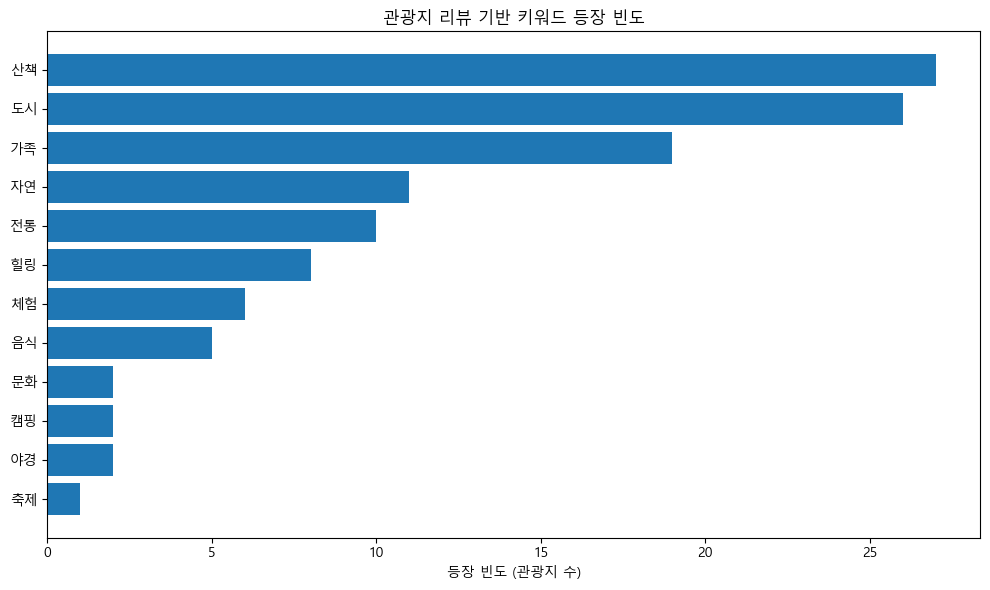

  keyword  count
5      산책     27
1      도시     26
4      가족     19
9      자연     11
2      전통     10

[실험] model: BM-K/KoSimCSE-roberta-multitask, threshold: 0.4 → C:/Users/User/Vscode/EDA25-1/data/keyword_exp_results/result_BM-K_KoSimCSE-roberta-multitask_th0.40_n2.csv


No sentence-transformers model found with name BM-K/KoSimCSE-roberta-multitask. Creating a new one with mean pooling.
Batches: 100%|██████████| 2/2 [00:00<00:00, 91.09it/s]


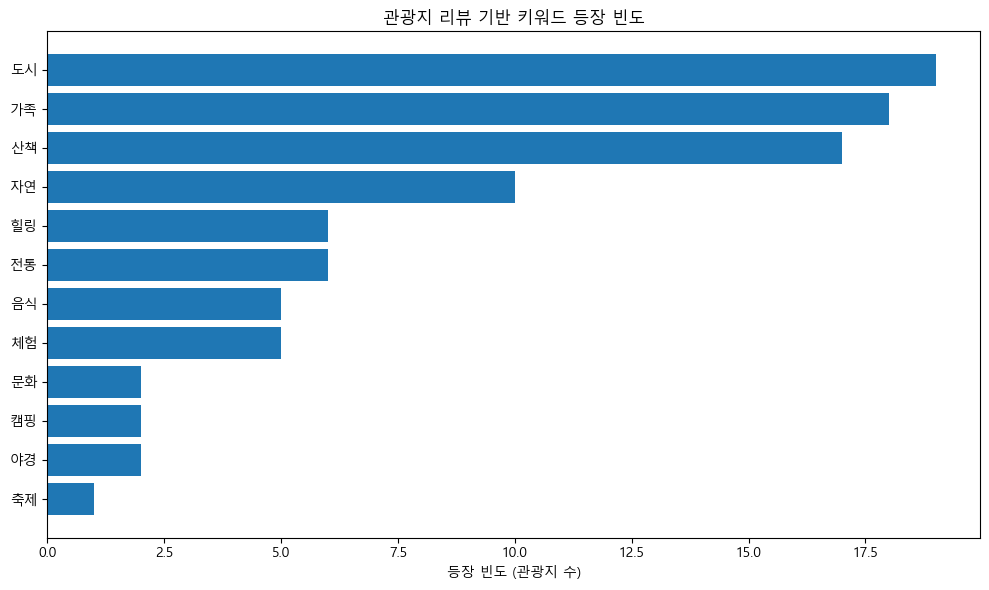

  keyword  count
1      도시     19
3      가족     18
4      산책     17
9      자연     10
6      전통      6

[실험] model: BM-K/KoSimCSE-roberta-multitask, threshold: 0.45 → C:/Users/User/Vscode/EDA25-1/data/keyword_exp_results/result_BM-K_KoSimCSE-roberta-multitask_th0.45_n2.csv


No sentence-transformers model found with name BM-K/KoSimCSE-roberta-multitask. Creating a new one with mean pooling.
Batches: 100%|██████████| 2/2 [00:00<00:00, 64.68it/s]


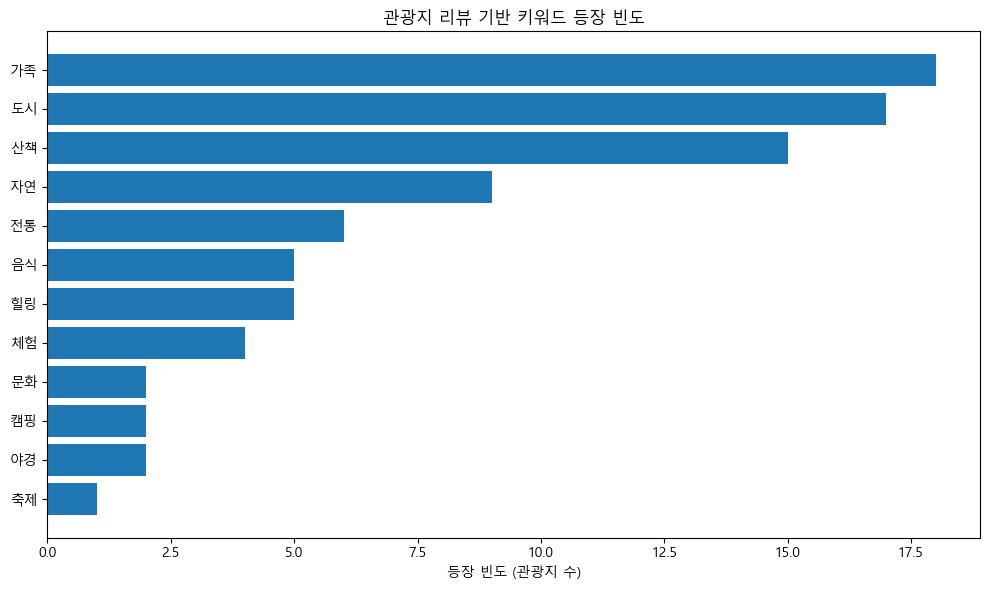

  keyword  count
3      가족     18
1      도시     17
4      산책     15
9      자연      9
6      전통      6

[실험] model: BM-K/KoSimCSE-roberta-multitask, threshold: 0.5 → C:/Users/User/Vscode/EDA25-1/data/keyword_exp_results/result_BM-K_KoSimCSE-roberta-multitask_th0.50_n2.csv


No sentence-transformers model found with name BM-K/KoSimCSE-roberta-multitask. Creating a new one with mean pooling.
Batches: 100%|██████████| 2/2 [00:00<00:00, 66.37it/s]


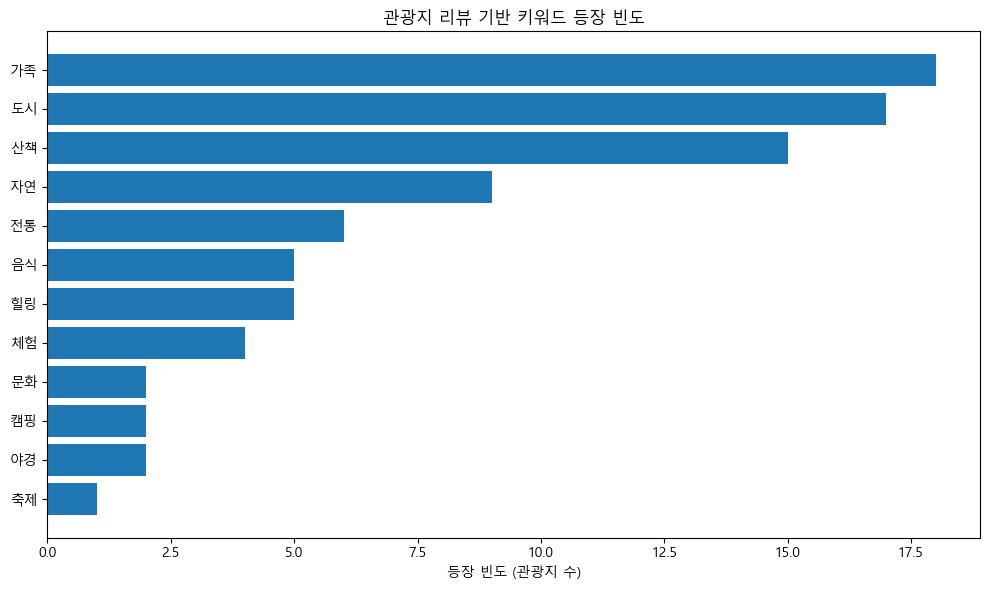

  keyword  count
3      가족     18
1      도시     17
4      산책     15
9      자연      9
6      전통      6

[실험] model: BM-K/KoSimCSE-bert-multitask, threshold: 0.3 → C:/Users/User/Vscode/EDA25-1/data/keyword_exp_results/result_BM-K_KoSimCSE-bert-multitask_th0.30_n2.csv


No sentence-transformers model found with name BM-K/KoSimCSE-bert-multitask. Creating a new one with mean pooling.
Batches: 100%|██████████| 2/2 [00:00<00:00, 59.47it/s]


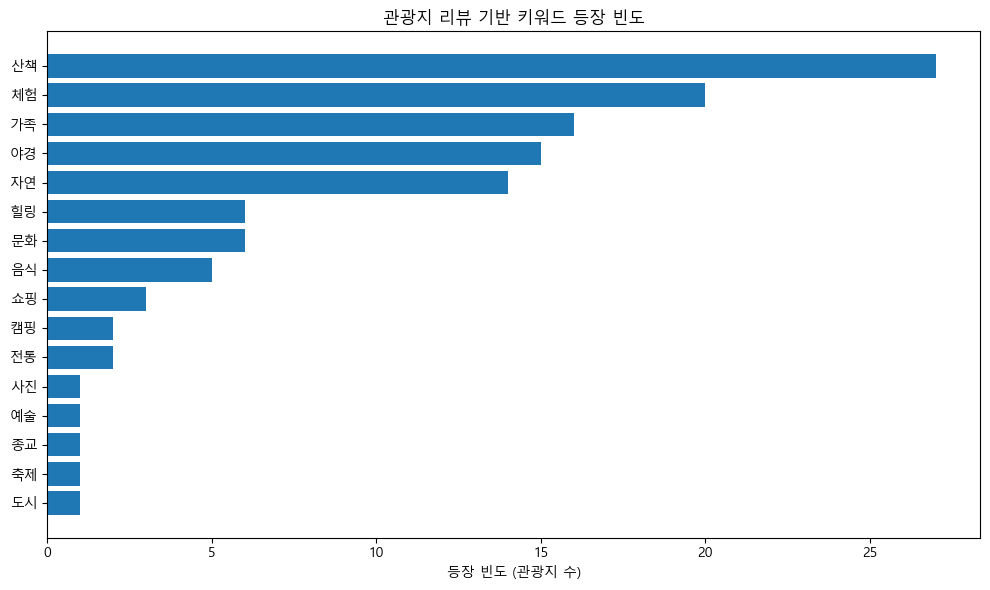

   keyword  count
5       산책     27
6       체험     20
4       가족     16
2       야경     15
11      자연     14

[실험] model: BM-K/KoSimCSE-bert-multitask, threshold: 0.35 → C:/Users/User/Vscode/EDA25-1/data/keyword_exp_results/result_BM-K_KoSimCSE-bert-multitask_th0.35_n2.csv


No sentence-transformers model found with name BM-K/KoSimCSE-bert-multitask. Creating a new one with mean pooling.
Batches: 100%|██████████| 2/2 [00:00<00:00, 63.58it/s]


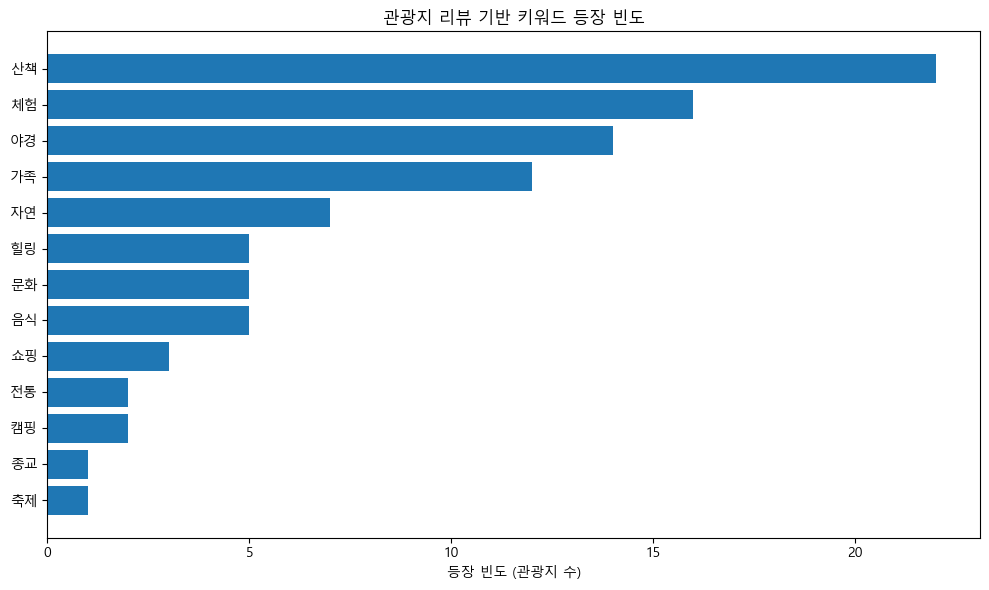

  keyword  count
4      산책     22
5      체험     16
2      야경     14
3      가족     12
9      자연      7

[실험] model: BM-K/KoSimCSE-bert-multitask, threshold: 0.4 → C:/Users/User/Vscode/EDA25-1/data/keyword_exp_results/result_BM-K_KoSimCSE-bert-multitask_th0.40_n2.csv


No sentence-transformers model found with name BM-K/KoSimCSE-bert-multitask. Creating a new one with mean pooling.
Batches: 100%|██████████| 2/2 [00:00<00:00, 57.17it/s]


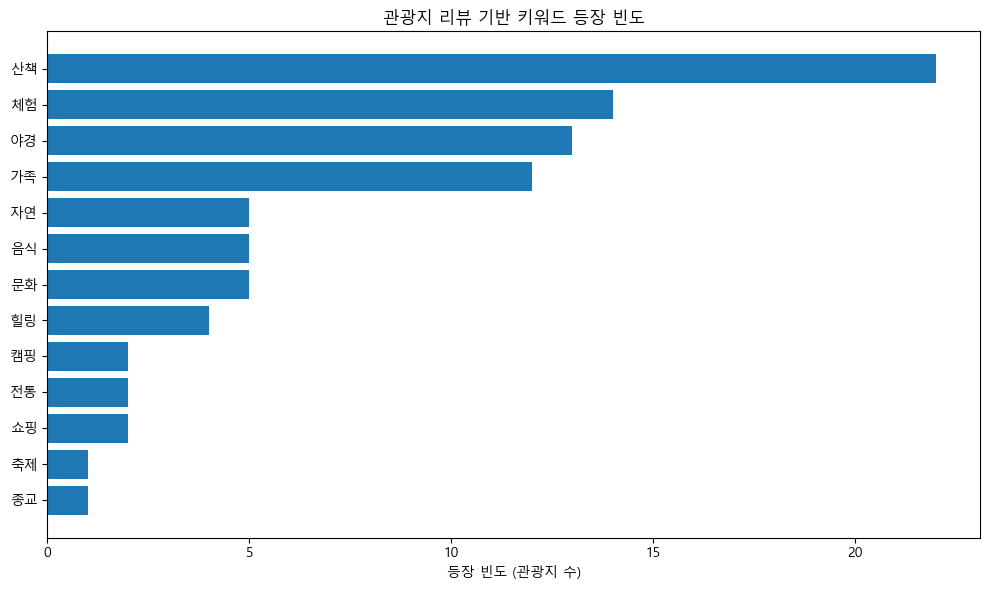

  keyword  count
4      산책     22
5      체험     14
2      야경     13
3      가족     12
0      음식      5

[실험] model: BM-K/KoSimCSE-bert-multitask, threshold: 0.45 → C:/Users/User/Vscode/EDA25-1/data/keyword_exp_results/result_BM-K_KoSimCSE-bert-multitask_th0.45_n2.csv


No sentence-transformers model found with name BM-K/KoSimCSE-bert-multitask. Creating a new one with mean pooling.
Batches: 100%|██████████| 2/2 [00:00<00:00, 63.43it/s]


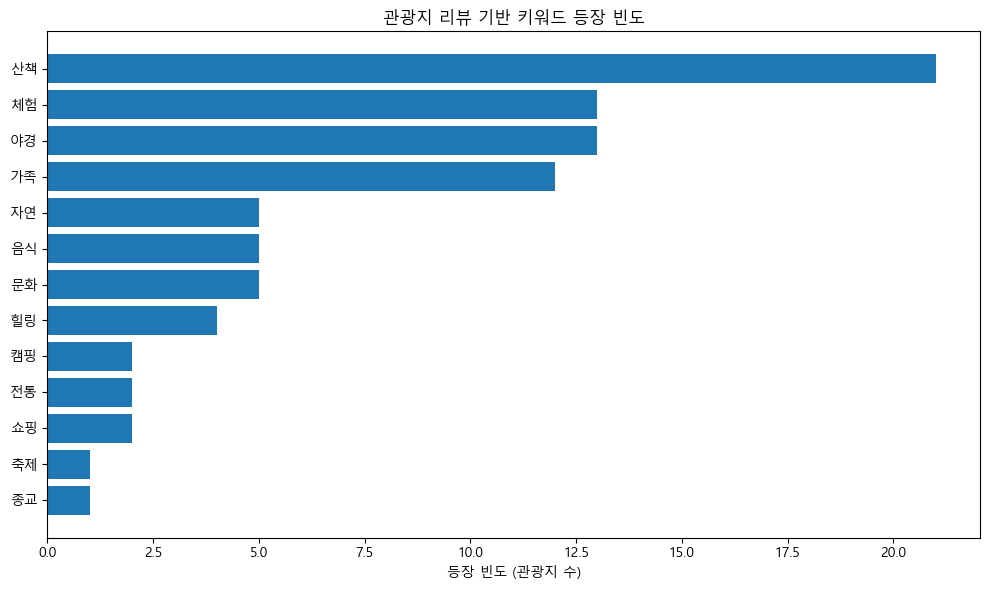

  keyword  count
4      산책     21
2      야경     13
5      체험     13
3      가족     12
0      음식      5

[실험] model: BM-K/KoSimCSE-bert-multitask, threshold: 0.5 → C:/Users/User/Vscode/EDA25-1/data/keyword_exp_results/result_BM-K_KoSimCSE-bert-multitask_th0.50_n2.csv


No sentence-transformers model found with name BM-K/KoSimCSE-bert-multitask. Creating a new one with mean pooling.
Batches: 100%|██████████| 2/2 [00:00<00:00, 51.99it/s]


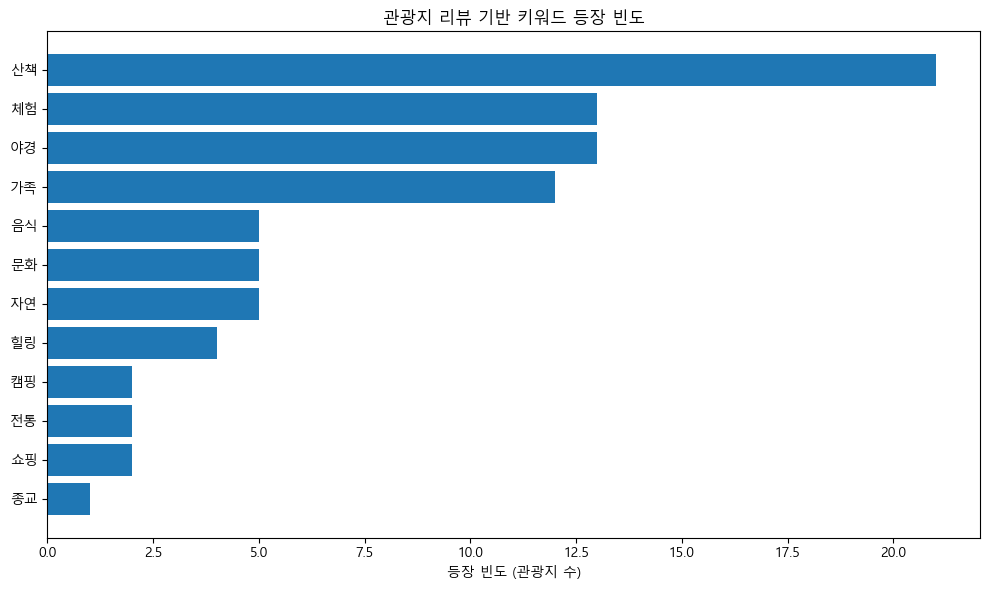

  keyword  count
4      산책     21
2      야경     13
5      체험     13
3      가족     12
6      문화      5

[실험] model: snunlp/KR-SBERT-V40K-klueNLI-augSTS, threshold: 0.3 → C:/Users/User/Vscode/EDA25-1/data/keyword_exp_results/result_snunlp_KR-SBERT-V40K-klueNLI-augSTS_th0.30_n2.csv


Batches: 100%|██████████| 2/2 [00:00<00:00, 37.79it/s]


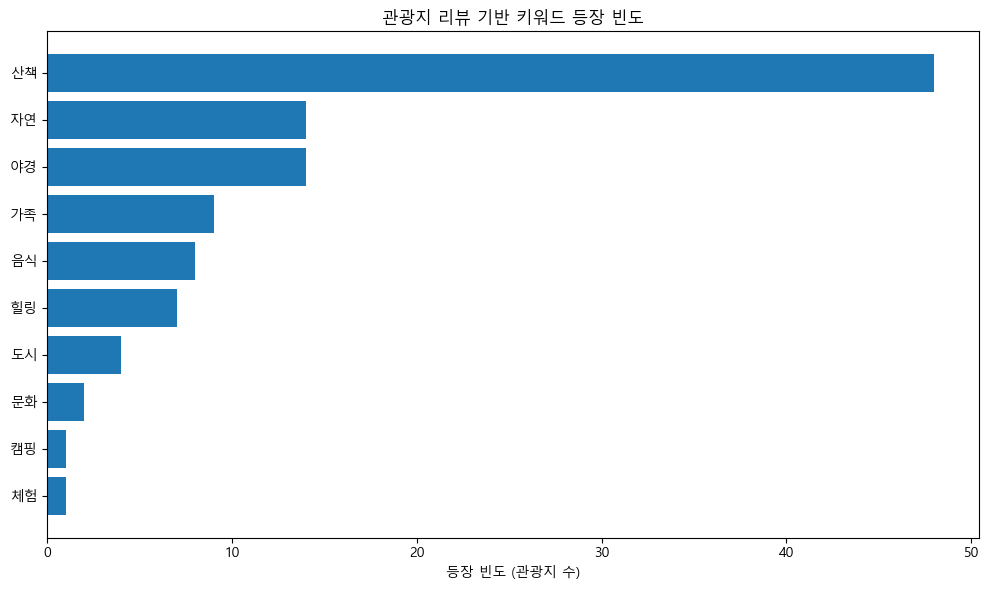

  keyword  count
6      산책     48
2      야경     14
4      자연     14
8      가족      9
0      음식      8

[실험] model: snunlp/KR-SBERT-V40K-klueNLI-augSTS, threshold: 0.35 → C:/Users/User/Vscode/EDA25-1/data/keyword_exp_results/result_snunlp_KR-SBERT-V40K-klueNLI-augSTS_th0.35_n2.csv


Batches: 100%|██████████| 2/2 [00:00<00:00, 62.86it/s]


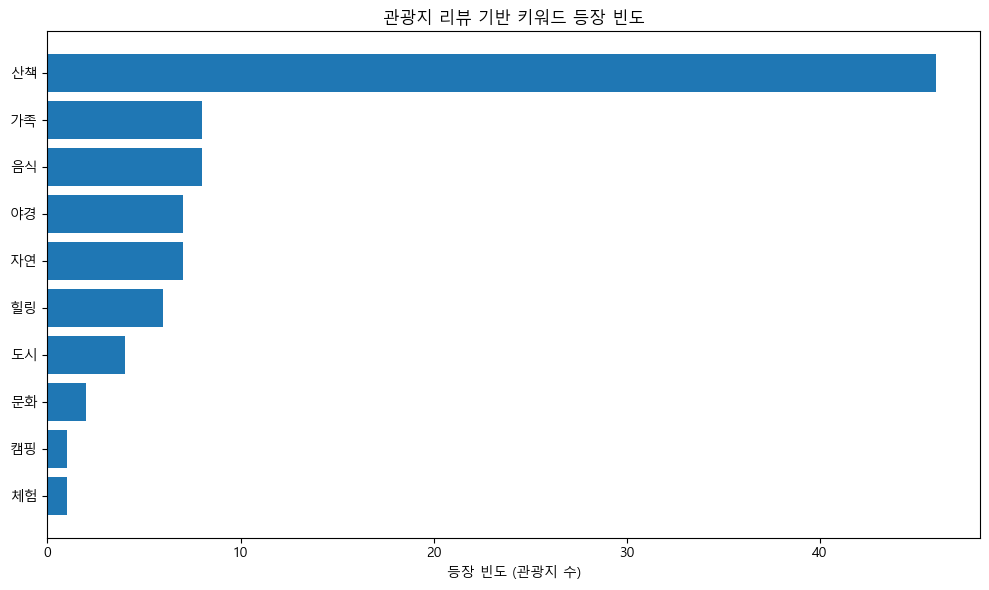

  keyword  count
6      산책     46
0      음식      8
8      가족      8
4      자연      7
2      야경      7

[실험] model: snunlp/KR-SBERT-V40K-klueNLI-augSTS, threshold: 0.4 → C:/Users/User/Vscode/EDA25-1/data/keyword_exp_results/result_snunlp_KR-SBERT-V40K-klueNLI-augSTS_th0.40_n2.csv


Batches: 100%|██████████| 2/2 [00:00<00:00, 30.87it/s]


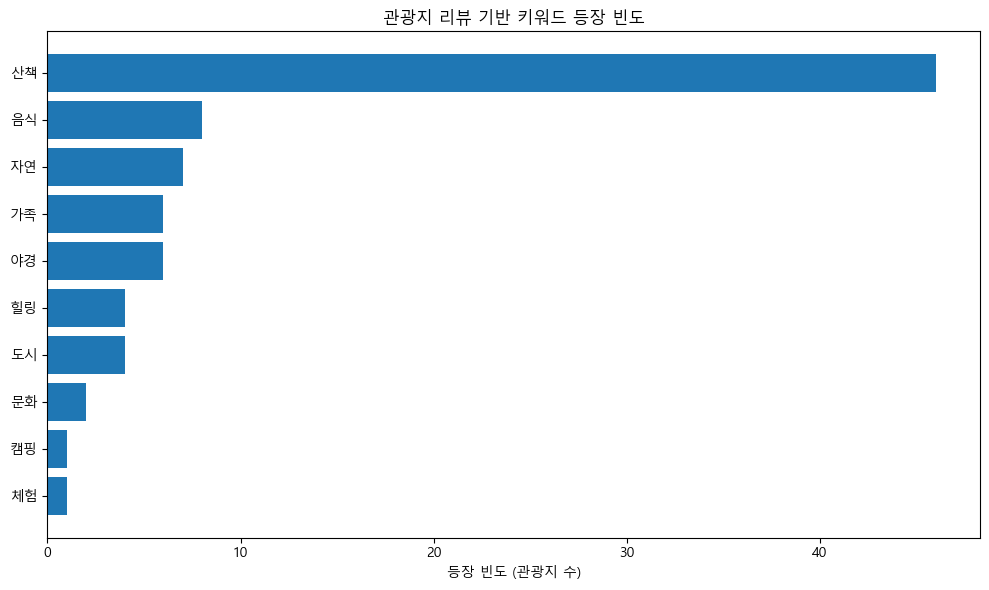

  keyword  count
6      산책     46
0      음식      8
4      자연      7
2      야경      6
8      가족      6

[실험] model: snunlp/KR-SBERT-V40K-klueNLI-augSTS, threshold: 0.45 → C:/Users/User/Vscode/EDA25-1/data/keyword_exp_results/result_snunlp_KR-SBERT-V40K-klueNLI-augSTS_th0.45_n2.csv


Batches: 100%|██████████| 2/2 [00:00<00:00, 42.30it/s]


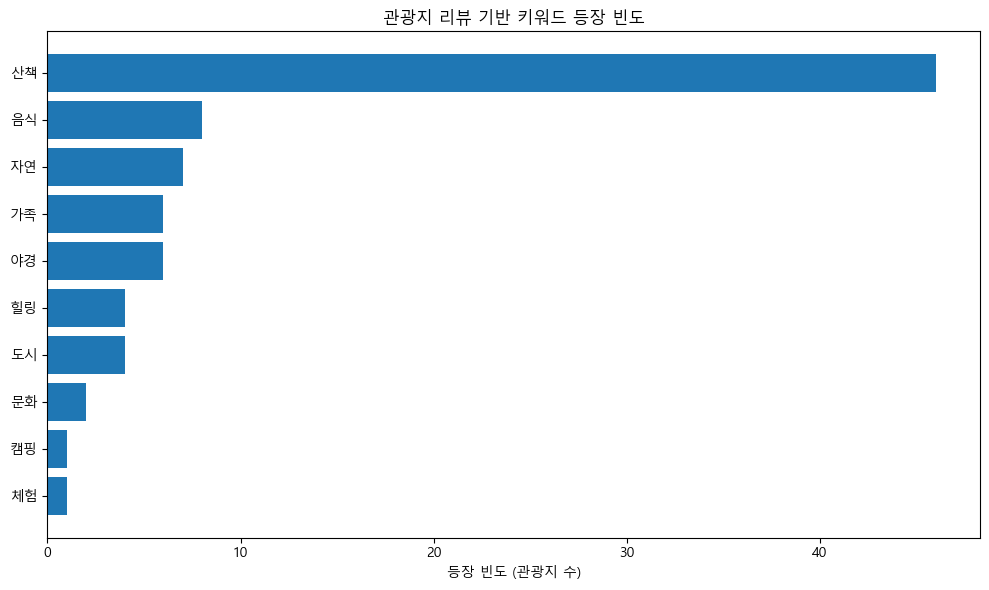

  keyword  count
6      산책     46
0      음식      8
4      자연      7
2      야경      6
8      가족      6

[실험] model: snunlp/KR-SBERT-V40K-klueNLI-augSTS, threshold: 0.5 → C:/Users/User/Vscode/EDA25-1/data/keyword_exp_results/result_snunlp_KR-SBERT-V40K-klueNLI-augSTS_th0.50_n2.csv


Batches: 100%|██████████| 2/2 [00:00<00:00, 33.97it/s]


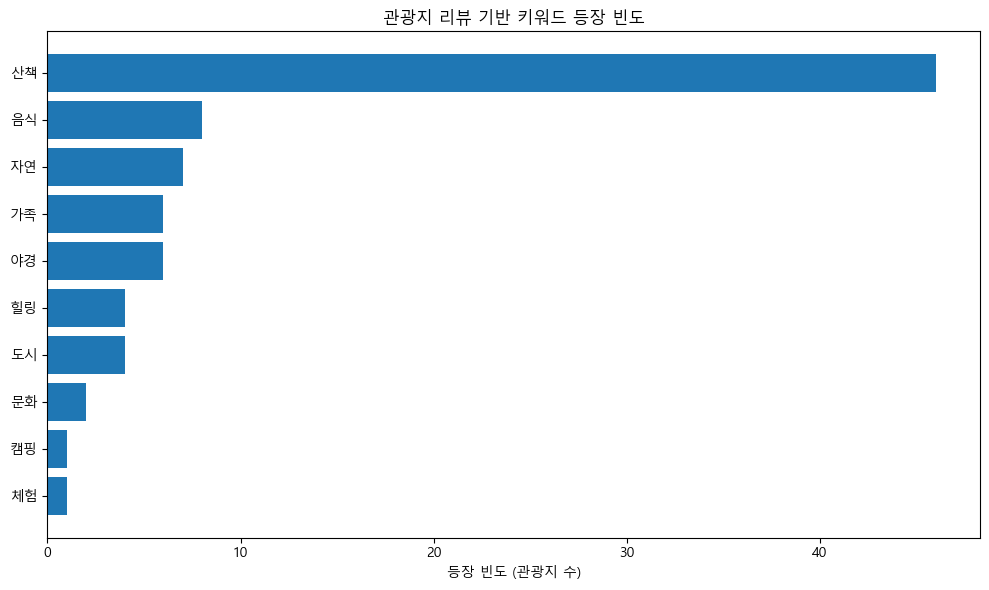

  keyword  count
6      산책     46
0      음식      8
4      자연      7
2      야경      6
8      가족      6

[실험] model: upskyy/bge-m3-korean, threshold: 0.3 → C:/Users/User/Vscode/EDA25-1/data/keyword_exp_results/result_upskyy_bge-m3-korean_th0.30_n2.csv


Batches: 100%|██████████| 2/2 [00:00<00:00, 72.24it/s]


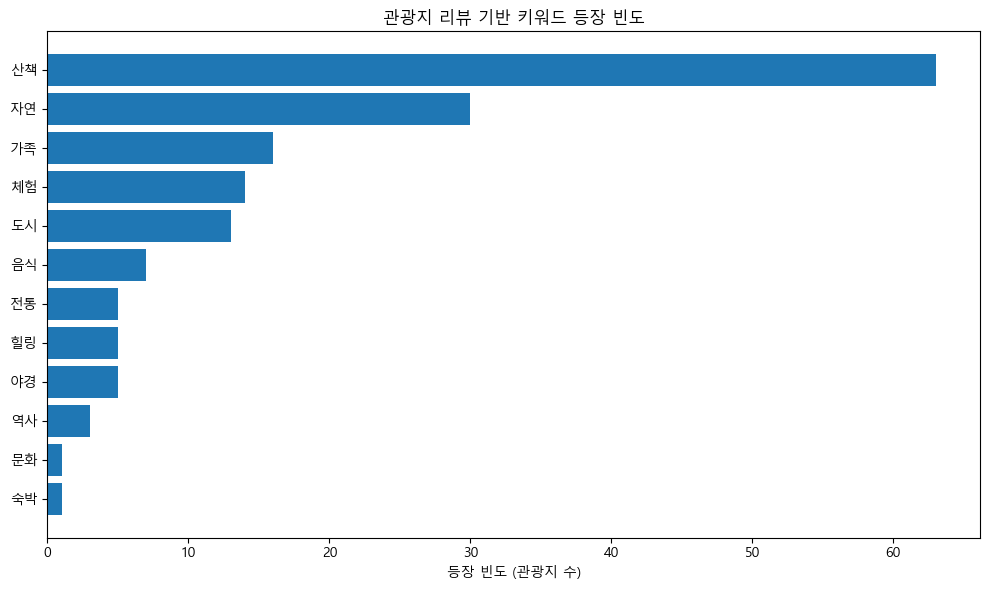

  keyword  count
1      산책     63
4      자연     30
5      가족     16
6      체험     14
2      도시     13

[실험] model: upskyy/bge-m3-korean, threshold: 0.35 → C:/Users/User/Vscode/EDA25-1/data/keyword_exp_results/result_upskyy_bge-m3-korean_th0.35_n2.csv


Batches: 100%|██████████| 2/2 [00:00<00:00, 17.51it/s]


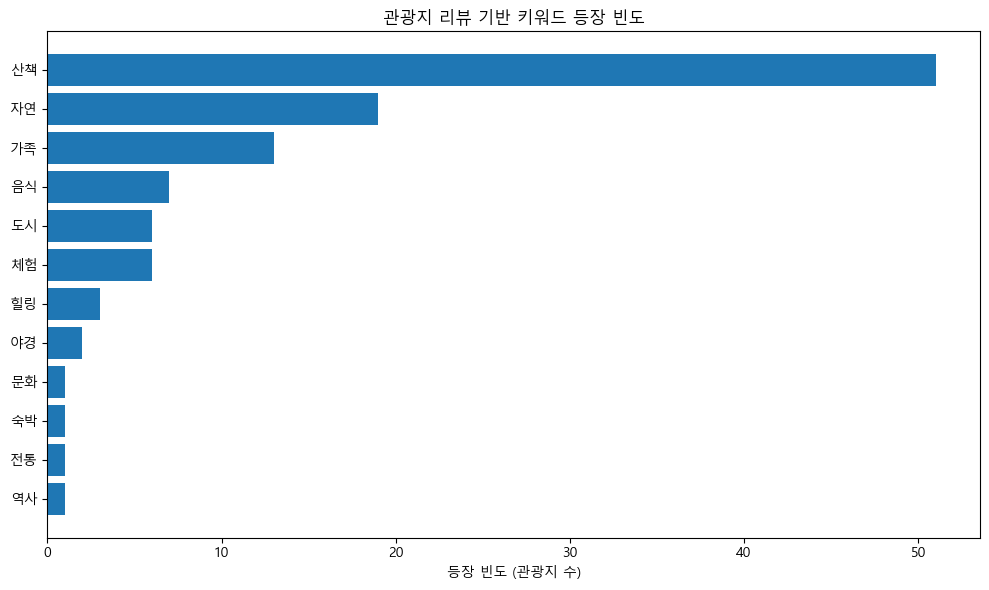

  keyword  count
1      산책     51
3      자연     19
4      가족     13
0      음식      7
5      체험      6

[실험] model: upskyy/bge-m3-korean, threshold: 0.4 → C:/Users/User/Vscode/EDA25-1/data/keyword_exp_results/result_upskyy_bge-m3-korean_th0.40_n2.csv


Batches: 100%|██████████| 2/2 [00:00<00:00, 15.86it/s]


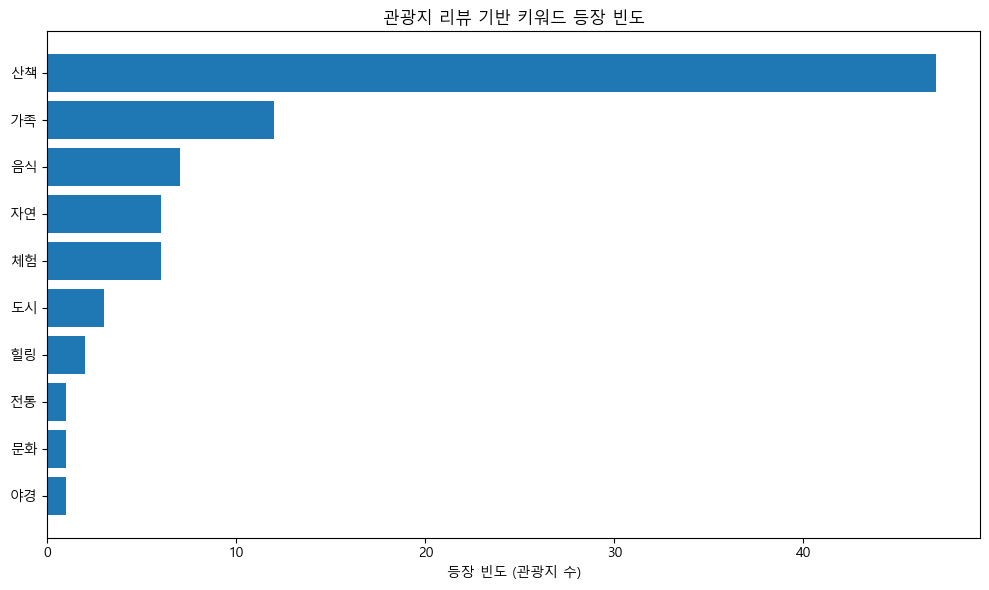

  keyword  count
1      산책     47
3      가족     12
0      음식      7
4      체험      6
8      자연      6

[실험] model: upskyy/bge-m3-korean, threshold: 0.45 → C:/Users/User/Vscode/EDA25-1/data/keyword_exp_results/result_upskyy_bge-m3-korean_th0.45_n2.csv


Batches: 100%|██████████| 2/2 [00:00<00:00, 21.14it/s]


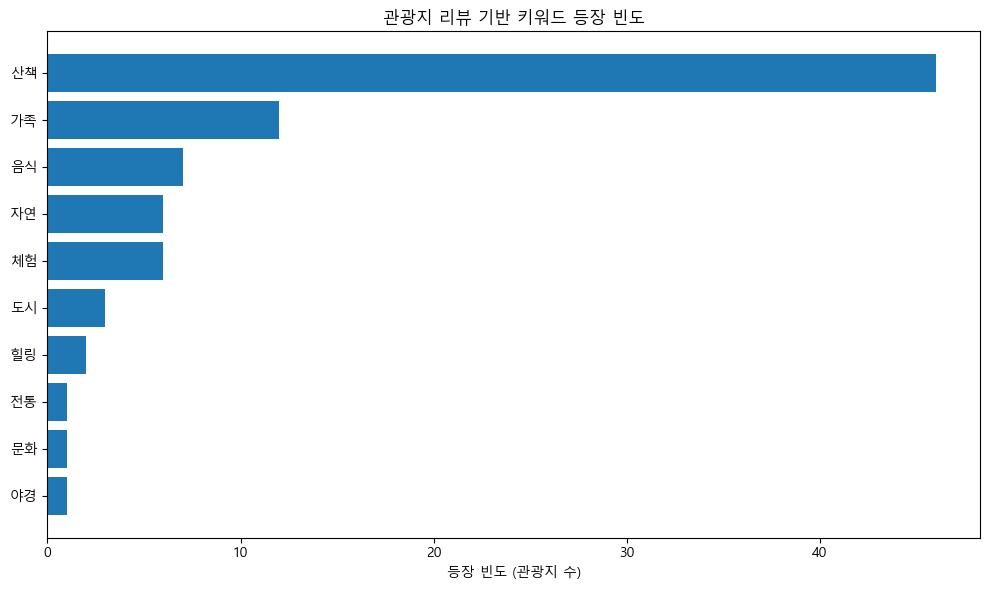

  keyword  count
1      산책     46
3      가족     12
0      음식      7
4      체험      6
8      자연      6

[실험] model: upskyy/bge-m3-korean, threshold: 0.5 → C:/Users/User/Vscode/EDA25-1/data/keyword_exp_results/result_upskyy_bge-m3-korean_th0.50_n2.csv


Batches: 100%|██████████| 2/2 [00:00<00:00, 14.06it/s]


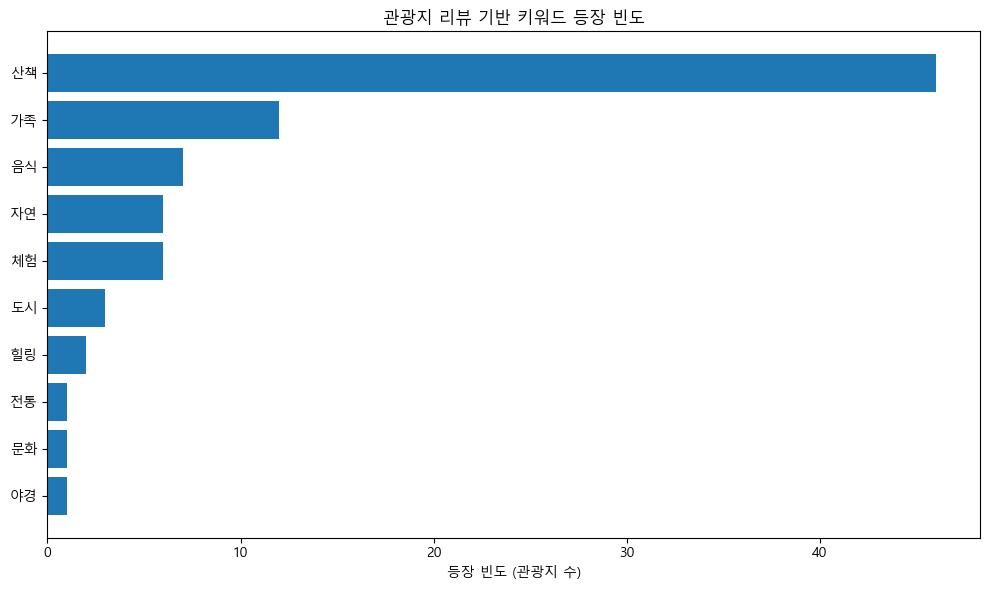

  keyword  count
1      산책     46
3      가족     12
0      음식      7
4      체험      6
8      자연      6

모든 실험이 완료되었습니다.


In [4]:
for model_name in model_list:
    for threshold in threshold_list:
        model_tag = model_name.replace('/', '_')
        out_file = f"{result_dir}/result_{model_tag}_th{threshold:.2f}_n{n}.csv"
        print(f"\n[실험] model: {model_name}, threshold: {threshold} → {out_file}")
        
        # show_plot=True로 그래프 자동 출력!
        place_sims, count_df = keyword_similarity_analysis(
            review_csv_path=csv_path,
            categories=categories,
            model_name=model_name,
            threshold=threshold,
            n=n,
            save_path=out_file,
            font_family=font_family,
            show_plot=True
        )
        print(count_df.sort_values('count', ascending=False).head())

print("\n모든 실험이 완료되었습니다.")